In [296]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

import cufflinks
plotly.__version__

'4.14.3'

In [297]:

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *


In [298]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [762]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    p = np.asmatrix(np.mean(returns, axis=1))
    w = rand_weights(returns.shape[0])
    C = np.asmatrix(np.cov(returns))
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    sharpe = mu/sigma
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, sharpe, np.array(w,dtype=object)

#derive efficient frontier
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    #weights = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[len(m1)-1] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    sr = np.array(returns)/np.array(risks)
    return returns, risks, sr

def get_ret_vol_sr(weights,returns):
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = weights
    C = np.asmatrix(np.cov(returns))
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    sharpe = mu/sigma
    
    return np.array([mu, sigma, sharpe])

import yfinance as yf
def dl(stock, start, end):
    subset = yf.download(stock, start=start, end=end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start:end]
    subset2 = subset[start:end]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)


array([ 4.26637865e+31, -2.14634894e+29,  4.63662889e+26, -5.63043891e+23,
        4.22669417e+20, -2.03300251e+17,  6.29039797e+13, -1.22687199e+10,
        1.43976542e+06, -7.90737867e+01,  2.08176457e-03])

In [412]:
import pandas as pd
end = pd.Timestamp.utcnow()
start = (end - 2500 * pd.tseries.offsets.BDay())
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [855]:
stocks_df = pd.DataFrame()
for i in range(0,len(stocks)):
    stocks_df = pd.concat([stocks_df,pd.DataFrame(stocks[i]).iloc[:,3]],axis=1)
    
stocks_df.columns = symbols

In [413]:
symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']

stocks = []
for i in symbols:
    stocks.append(dl(i,start,end))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [414]:
return_vec = np.zeros(shape=(len(stocks),len(stocks[0].iloc[:,3])-1))

for i in range(0,len(stocks)):
    intArray = np.array(np.log(1+stocks[i].iloc[:,3].pct_change().dropna()))
    return_vec[i] = intArray


Text(0, 0.5, 'returns')

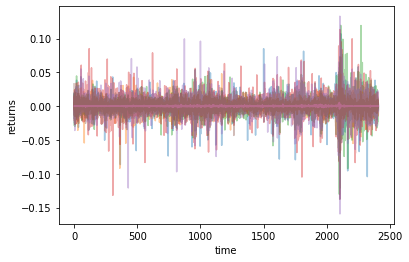

In [415]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py 
from plotly.graph_objs import *

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
#py.iplot_mpl(fig, filename='s6_damped_oscillation')

In [820]:

n_portfolios = 500

#, returns, variances, sharpes, weights
means, stds, sharpes, weights = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])


/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Optimal Monte Carlo sharpe ratio: [[0.07000393]]
Its location in the array: 260


,0
IBM,0.0311292
GLD,0.00616419
XOM,0.0684123
AAPL,0.225779
MSFT,0.199058
TLT,0.291929
SHY,0.177528


Optimal Monte Carlo Expected Daily Return: 0.0004805390696580362
Optimal Monte Carlo Expected Daily Variance: 0.006864458870260699
Optimal Monte Carlo Expected Annual Return: 0.12145624985606865


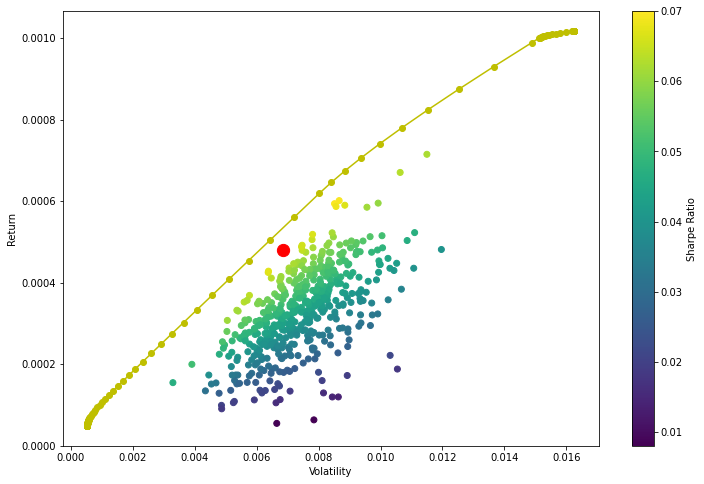

In [821]:
returns, risks, opt_sharpes = optimal_portfolio(return_vec)

print('Optimal Monte Carlo sharpe ratio: {}'.format(sharpes.max()))
print('Its location in the array: {}'.format(sharpes.argmax()))

display(pd.DataFrame(weights[sharpes.argmax()]).set_index(np.array(symbols)))
max_sr_ret = np.array(means[sharpes.argmax()])[0][0]
max_sr_vol = np.array(stds[sharpes.argmax()])[0][0]

print('Optimal Monte Carlo Expected Daily Return: {}'.format(max_sr_ret))
print('Optimal Monte Carlo Expected Daily Variance: {}'.format(max_sr_vol))
print('Optimal Monte Carlo Expected Annual Return: {}'.format(max_sr_ret*252.75))

plt.figure(figsize=(12,8))
plt.scatter(stds, means, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(risks, returns, 'y-o')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=150) # red dot
plt.show()

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



array([[[0.00042649]],

       [[0.00610405]],

       [[0.06987007]]])

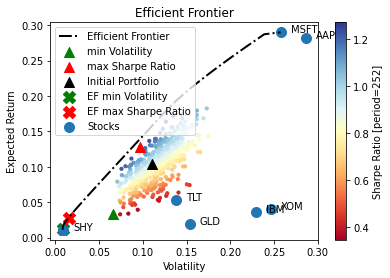

In [868]:
from finquant.portfolio import build_portfolio
pf = build_portfolio(data=stocks_df)

# performs and plots results of Monte Carlo run (5000 iterations)
opt_w, opt_res = pf.mc_optimisation(num_trials=500)
# plots the results of the Monte Carlo optimisation
pf.mc_plot_results()
# plots the Efficient Frontier
pf.ef_plot_efrontier()
# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()
# plots individual plots of the portfolio
pf.plot_stocks()

get_ret_vol_sr(opt_w.loc['Max Sharpe Ratio'].values,return_vec)